Thanks to https://www.kaggle.com/cdeotte/data-without-drift.

Thanks to https://www.kaggle.com/ragnar123/clean-kalman #Clean data with kelman Filter


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
B_NUM = 10
B_SIZE = 500000

In [0]:
!pip install tensorflow==1.14


     |████████████████████████████████| 109.2MB 83kB/s 
     |████████████████████████████████| 491kB 41.7MB/s 
     |████████████████████████████████| 3.2MB 45.8MB/s 
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow 2.2.0rc4
    Uninstalling tensorflow-2.2.0rc4:
      Successfully uninstalled tensorflow-2.2.0rc4


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# imports
import numpy as np 
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, plot_confusion_matrix
from keras.models import Model
import keras.layers as L
import lightgbm as lgb
from keras.layers import LeakyReLU
from scipy import fftpack
import librosa
import tensorflow as tf


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission_unshifted_70p.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/a-signal-processing-approach-low-pass-filtering.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/3-simple-ideas-lb-0-938.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/use_sound_feature.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/submission_XGBoost.csv
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/simple_Boosting.ipynb
./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean_kalman.csv
./drive/My Drive/Colab Notebooks/liverp

In [0]:
tf.__version__

'2.2.0-rc4'

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024 ** 2 # just added 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df

In [0]:
kal_data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean_kalman.csv')
data = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_clean.csv')

# Y_train_proba = np.load("./drive/My Drive/Colab Notebooks/liverpool-ion-switching/Y_train_proba.npy")

# for i in range(11):
#     data[f"proba_{i}"] = Y_train_proba[:, i]

# data = data[B_SIZE:2*B_SIZE]
# data.reset_index(inplace=True)
# data.drop('index', axis=1, inplace=True)
data

,time,signal,open_channels
0,0.0001,-2.760000,0
1,0.0002,-2.855700,0
2,0.0003,-2.407400,0
3,0.0004,-3.140400,0
4,0.0005,-3.152500,0
...,...,...,...
4999995,499.9996,2.932577,7
4999996,499.9997,2.711208,7
4999997,499.9998,4.529640,8
4999998,499.9999,5.652972,9


**Feature Engineering**: Thanks to  https://www.kaggle.com/martxelo/fe-and-simple-mlp 

In [0]:
def calc_gradients(s, n_grads=4):
    '''
    Calculate gradients for a pandas series. Returns the same number of samples
    '''
    grads = pd.DataFrame()
    
    g = s.values
    for i in range(n_grads):
        g = np.gradient(g)
        grads['grad_' + str(i+1)] = g
        
    return grads

In [0]:
def calc_low_pass(s, n_filts=10):
    '''
    Applies low pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.3, n_filts)
    
    low_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='low')
        zi = signal.lfilter_zi(b, a)
        low_pass['lowpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        low_pass['lowpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return low_pass

In [0]:
def calc_high_pass(s, n_filts=10):
    '''
    Applies high pass filters to the signal. Left delayed and no delayed
    '''
    wns = np.logspace(-2, -0.1, n_filts)
    
    high_pass = pd.DataFrame()
    x = s.values
    for wn in wns:
        b, a = signal.butter(1, Wn=wn, btype='high')
        zi = signal.lfilter_zi(b, a)
        high_pass['highpass_lf_' + str('%.4f' %wn)] = signal.lfilter(b, a, x, zi=zi*x[0])[0]
        high_pass['highpass_ff_' + str('%.4f' %wn)] = signal.filtfilt(b, a, x)
        
    return high_pass

In [0]:
def calc_roll_stats(s, windows=[5, 10, 50, 100, 500, 1000]):
    '''
    Calculates rolling stats like mean, std, min, max...
    '''
    roll_stats = pd.DataFrame()
    for w in windows:
        r = s.rolling(window=w, min_periods=1, center=True)
        roll_stats['roll_mean_' + str(w)] = r.mean()
        roll_stats['roll_std_' + str(w)] = r.std()
        roll_stats['roll_min_' + str(w)] = r.min()
        roll_stats['roll_max_' + str(w)] = r.max()
        roll_stats['roll_range_' + str(w)] = roll_stats['roll_max_' + str(w)] - roll_stats['roll_min_' + str(w)]
        roll_stats['roll_median_' + str(w)] = r.median()
        # roll_stats['roll_skew_' + str(w)] = r.skew()
        # roll_stats['roll_q10_' + str(w)] = r.quantile(0.10)
        # roll_stats['roll_q25_' + str(w)] = r.quantile(0.25)
        # roll_stats['roll_q50_' + str(w)] = r.quantile(0.50)
        # roll_stats['roll_q75_' + str(w)] = r.quantile(0.75)
        # roll_stats['roll_q90_' + str(w)] = r.quantile(0.90)
        # roll_stats['roll_agg_sum' + str(w)] = r.aggregate(np.sum)
        # roll_stats['roll_agg_mean' + str(w)] = r.aggregate(np.mean)
        # roll_stats['roll_agg_std' + str(w)] = r.aggregate(np.std)
    
    # add zeros when na values (std)
    roll_stats = roll_stats.fillna(value=0)
             
    return roll_stats

In [0]:
def calc_ewm(s, windows=[5, 10, 50, 100, 500, 1000]):
    '''
    Calculates exponential weighted functions
    '''
    ewm = pd.DataFrame()
    for w in windows:
        e = s.ewm(span=w, min_periods=1)
        ewm['ewm_mean_' + str(w)] = e.mean()
        ewm['ewm_std_' + str(w)] = e.std()

        # ewm['ewm_agg_mean' + str(w)] = e.aggregate(np.mean)
        # ewm['ewm_agg_std' + str(w)] = e.aggregate(np.std)
        
    # add zeros when na values (std)
    ewm = ewm.fillna(value=0)
        
    return ewm

In [0]:
# get lead and lags features
def lag_with_pct_change(s, windows):
    shift = pd.DataFrame()
    for window in windows:    
        shift['signal_shift_pos_' + str(window)] = s.shift(window).fillna(0)
        shift['signal_shift_neg_' + str(window)] = s.shift(-1 * window).fillna(0)
    return shift

In [0]:
def calc_mfcc(s, signal_size, windows=[128, 256, 512, 1024]):

  mfcc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    mfcc_ = librosa.feature.mfcc(y=s.values, n_mfcc=12, sr=96000, hop_length=window, n_fft=window, n_mels=int(window/16))
    mfcc_lists = []
    for i in range(len(mfcc_[0])):
      mfcc_list = [mfcc_[0][i]] * window
      mfcc_lists.extend(mfcc_list)
    mfcc['signal_mfcc_' + str(window)] = mfcc_lists[:signal_size]
  # print(len(mfcc))

  return mfcc

In [0]:
def spectral_centroid(s, windows=[100, 500, 1000]):

  sc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    sc_ = librosa.feature.spectral_centroid(y=s.values, sr=96000, hop_length=window, n_fft=window)
    sc_lists = []
    for i in range(len(sc_[0])):
      sc_list = [sc_[0][i]] * window
      sc_lists.extend(sc_list)
    sc['signal_sc' + str(window)] = sc_lists[:500000]
  # print(len(mfcc))

  return sc

In [0]:
def calc_roll_off(s, windows=[100, 500, 1000]):

  sc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    sc_ = librosa.feature.spectral_rolloff(y=s.values, sr=96000, hop_length=window, n_fft=window)
    sc_lists = []
    for i in range(len(sc_[0])):
      sc_list = [sc_[0][i]] * window
      sc_lists.extend(sc_list)
    sc['signal_sc' + str(window)] = sc_lists[:500000]
  # print(len(mfcc))

  return sc

In [0]:
def calc_zerocross(s, windows=[500]):

  zc = pd.DataFrame()
  for window in windows:
    # mfcc['signal_mfcc_' + str(window)] = librosa.feature.mfcc(y=s.values(), sr=window, hop_length=int(window/2))
    zc_ = librosa.feature.zero_crossing_rate(y=s.values, frame_length=window, hop_length=window)
    zc_lists = []
    for i in range(len(zc_[0])):
      zc_list = [zc_[0][i]] * window
      zc_lists.extend(zc_list)
    zc['signal_zc_' + str(window)] = zc_lists[:500000]

  # print(len(zc_[0]))

  return zc

In [0]:
def add_group(me, i, signal_size=500000):
  if(me == 'train'):
    df_group = pd.DataFrame()
    num = [0, 0, 1, 2, 3, 4, 1, 2, 4, 3]
    lst = [num[i]] * signal_size
    df_group['group'] = lst
    # df = pd.concat([df, df_group], axis=1)

  else:
    df_group = pd.DataFrame()
    num = [0, 2, 3, 0, 1, 4, 3, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0]
    lst = [num[i]] * signal_size
    df_group['group'] = lst

  return df_group


In [0]:
def add_features(s, me, i, signal_size):
    '''
    All calculations together
    '''
    
    gradients = calc_gradients(s)
    low_pass = calc_low_pass(s)
    high_pass = calc_high_pass(s)
    roll_stats = calc_roll_stats(s)
    ewm = calc_ewm(s)
    shift = lag_with_pct_change(s, [1, 2, 3])
    mfcc = calc_mfcc(s, signal_size)
    # zc = calc_zerocross(s)
    # sc = spectral_centroid(s)
    # ro = calc_roll_off(s)
    # gr = add_group('train', i)
    # agg = calc_agg(s)
    # fft_ = calc_fft(s)
    # print('ewm = ', len(fft_))
    
    return pd.concat([s, gradients, low_pass, high_pass, roll_stats, ewm, shift, mfcc], axis=1)


def divide_and_add_features(s, me, signal_size=500000):
    '''
    Divide the signal in bags of "signal_size".
    Normalize the data dividing it by 15.0
    '''
    # normalize
    # s = s/15.0

    # s = remove_batch7_spike(s)
    plt.plot(s)
    
    ls = []
    for i in tqdm(range(int(s.shape[0]/signal_size))):
        sig = s[i*signal_size:(i+1)*signal_size].copy().reset_index(drop=True)
        sig_featured = add_features(sig, me, i, signal_size)
        ls.append(sig_featured)
        # break
    
    return pd.concat(ls, axis=0)

def remove_batch7_spike(df):
    b_size = 500000
    
    df['signal_aranged'] = df['signal'].values
    
    data_7 = df[7*b_size:8*b_size]
    
    batch7_outlier_idx = data_7.query('signal_aranged >= 2.2 or signal_aranged <= -3.7').index

    # print(df['signal_aranged'][batch7_outlier_idx[0]])
    # batch7_outlier_idx_ = pd.Int64Index(range(batch7_outlier_idx[0], batch7_outlier_idx[-1] + 1))
    df['signal_aranged'][batch7_outlier_idx] = 1
    
    return df

100%|██████████| 10/10 [00:44<00:00,  4.49s/it]


Mem. usage decreased from 3967.29 Mb to 1020.43 Mb (74.3% reduction)


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_median_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_median_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_median_1000,ewm_mean_5,ewm_std_5,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_mfcc_128,signal_mfcc_256,signal_mfcc_512,signal_mfcc_1024,raw_signal
0,-2.759766,-0.087402,0.255615,-0.282227,0.022476,-2.759766,-2.792969,-2.759766,-2.796875,-2.759766,-2.792969,-2.759766,-2.783203,-2.759766,-2.771484,-2.759766,-2.763672,-2.759766,-2.761719,-2.759766,-2.759766,-2.759766,-2.759766,-2.759766,-2.759766,0.000000,0.032471,-0.000000,0.036194,0.000000,0.030609,0.000000,0.018738,0.000000,0.007477,0.000000,0.001335,0.000000,-0.000128,0.000000,...,0.245239,-3.199219,-2.058594,1.140625,-2.824219,-2.722656,0.243286,-3.341797,-2.058594,1.283203,-2.728516,-2.708984,0.242432,-3.367188,-2.058594,1.307617,-2.699219,-2.759766,0.000000,-2.759766,0.000000,-2.759766,0.000000,-2.759766,0.000000,-2.759766,0.000000,-2.759766,0.000000,0.000000,-2.847656,0.000000,-2.423828,0.000000,-3.130859,-47.750000,-56.937500,-58.750000,-51.71875,-2.7600
1,-2.847656,0.168213,-0.026810,-0.259766,0.195557,-2.761719,-2.792969,-2.763672,-2.796875,-2.763672,-2.794922,-2.765625,-2.785156,-2.767578,-2.775391,-2.771484,-2.771484,-2.775391,-2.769531,-2.783203,-2.761719,-2.791016,-2.742188,-2.804688,-2.720703,-0.085999,-0.055206,-0.085205,-0.050934,-0.083862,-0.055634,-0.081848,-0.066162,-0.078674,-0.075073,-0.074036,-0.078613,-0.067261,-0.082642,-0.057861,...,0.243042,-3.199219,-2.058594,1.140625,-2.847656,-2.722656,0.242920,-3.341797,-2.058594,1.283203,-2.728516,-2.708984,0.242188,-3.367188,-2.058594,1.307617,-2.699219,-2.812500,0.061798,-2.808594,0.061798,-2.804688,0.061798,-2.804688,0.061798,-2.804688,0.061798,-2.804688,0.061798,-2.759766,-2.423828,0.000000,-3.130859,0.000000,-3.144531,-47.750000,-56.937500,-58.750000,-51.71875,-2.8557
2,-2.423828,-0.140991,-0.264160,0.108643,0.269043,-2.757812,-2.792969,-2.755859,-2.796875,-2.753906,-2.794922,-2.751953,-2.789062,-2.746094,-2.781250,-2.738281,-2.781250,-2.726562,-2.785156,-2.708984,-2.787109,-2.679688,-2.767578,-2.636719,-2.707031,0.333740,0.368164,0.332275,0.373291,0.329590,0.369629,0.325439,0.361084,0.318604,0.355957,0.307617,0.359131,0.289795,0.363525,0.261719,...,0.244873,-3.199219,-2.058594,1.140625,-2.851562,-2.720703,0.243286,-3.341797,-2.058594,1.283203,-2.728516,-2.708984,0.242554,-3.367188,-2.058594,1.307617,-2.699219,-2.628906,0.247314,-2.654297,0.236084,-2.673828,0.226196,-2.675781,0.224976,-2.677734,0.223999,-2.677734,0.223877,-2.847656,-3.130859,-2.759766,-3.144531,0.000000,-2.650391,-47.750000,-56.937500,-58.750000,-51.71875,-2.4074
3,-3.130859,-0.360352,0.190552,0.278076,-0.128662,-2.757812,-2.792969,-2.757812,-2.798828,-2.755859,-2.796875,-2.753906,-2.792969,-2.751953,-2.789062,-2.748047,-2.796875,-2.744141,-2.818359,-2.744141,-2.853516,-2.750000,-2.900391,-2.777344,-2.957031,-0.371338,-0.337646,-0.372559,-0.331787,-0.374268,-0.333740,-0.376953,-0.339355,-0.380371,-0.338623,-0.384277,-0.322266,-0.386719,-0.287842,-0

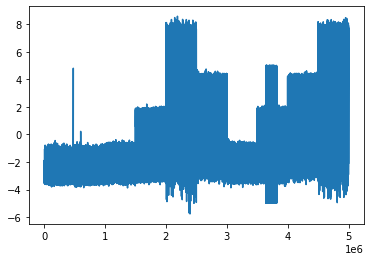

In [0]:
# apply every feature to data
# kal_df = divide_and_add_features(kal_data['signal'])
# df = divide_and_add_features(data['signal'])

df = divide_and_add_features(kal_data['signal'], 'train', 500000)
df = reduce_mem_usage(df)   ##Reduce memory usage
df = df.reset_index(drop=True)
# df = remove_batch7_spike(df)

raw_train = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train.csv')
df['raw_signal'] = raw_train['signal'].values

# feats= []
# for feat in kal_df.columns :
#   feats.append('kal_' + feat)
# kal_df.columns = feats

# df = pd.concat([df, kal_df], axis=1) 

df

In [0]:
df = reduce_mem_usage(df)   ##Reduce memory usage

Mem. usage decreased from 1020.43 Mb to 991.82 Mb (2.8% reduction)


In [0]:
# df1 = df[B_SIZE:B_SIZE*2]
# df = df[0:B_SIZE]

In [0]:
X = df
y = data["open_channels"]

In [0]:
mfcc_ = pd.DataFrame()
mfcc_['roll_max_1000'] =  X['roll_max_1000'].values
mfcc_.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_roll_max_1000.csv', index=False)

In [0]:
# y1 = y[B_SIZE:B_SIZE*2]
# y = y[0:B_SIZE]

**Calculatting Class weight**

class_weight= [  4.03176385   5.07168831   9.02650905   7.47821223  12.39433827
  17.9935727   26.57990984  18.86685659  20.39293099  36.73229503
 139.92667842]


Text(0.5, 1.0, 'class_weight')

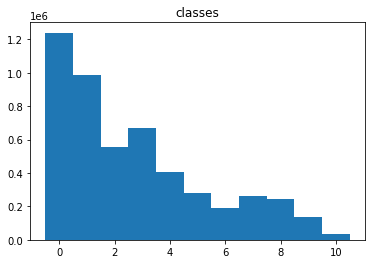

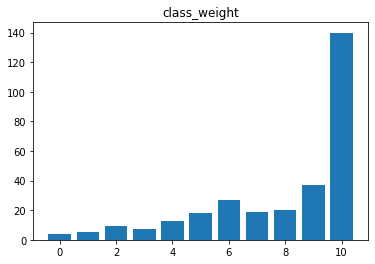

In [0]:
def get_class_weight(classes, exp=1):
    '''
    Weight of the class is inversely proportional to the population of the class.
    There is an exponent for adding more weight.
    '''
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

class_weight = get_class_weight(y)
print('class_weight=', class_weight)
plt.figure()
plt.title('classes')
plt.hist(y, bins=np.arange(12)-0.5)
plt.figure()
plt.title('class_weight')
plt.bar(np.arange(11), class_weight)
plt.title('class_weight')

Reading test data

Reading data...


  0%|          | 0/200 [00:00<?, ?it/s]

Feature engineering...


100%|██████████| 200/200 [00:32<00:00,  6.11it/s]


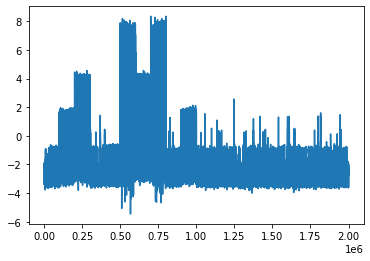

In [0]:
print('Reading data...')
# kal_td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean_kalman.csv')
# td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean.csv')
td = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_clean_kalman.csv')
# plt.plot(td['signal'])
# Y_test_proba = np.load("./drive/My Drive/Colab Notebooks/liverpool-ion-switching/Y_test_proba.npy")

# for i in range(11):
#     td[f"proba_{i}"] = Y_test_proba[:, i]
# td = td[B_SIZE:2*B_SIZE]
# td.reset_index(inplace=True)
# td.drop('index', axis=1, inplace=True)
    
print('Feature engineering...')
# kal_tdf = divide_and_add_features(td['signal'])
tdf = divide_and_add_features(td['signal'], 'test', 10000)
tdf = tdf.reset_index(drop=True)
# tdf = remove_batch7_spike(tdf)

raw_test = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test.csv')
tdf['raw_signal'] = raw_test['signal'].values
# feats= []
# for feat in kal_tdf.columns :
#   feats.append('kal_' + feat)
# kal_tdf.columns = feats

# tdf = pd.concat([tdf, kal_tdf], axis=1) 

In [0]:
tdf = reduce_mem_usage(tdf)
tdf

Mem. usage decreased from 1586.91 Mb to 396.73 Mb (75.0% reduction)


,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_median_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_median_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_median_1000,ewm_mean_5,ewm_std_5,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_mfcc_128,signal_mfcc_256,signal_mfcc_512,signal_mfcc_1024,raw_signal
0,-2.650391,-0.195312,0.094055,0.104309,-0.095886,-2.650391,-2.628906,-2.650391,-2.632812,-2.650391,-2.640625,-2.650391,-2.648438,-2.650391,-2.652344,-2.650391,-2.652344,-2.650391,-2.652344,-2.650391,-2.652344,-2.650391,-2.650391,-2.650391,-2.650391,0.000000,-0.023331,-0.000000,-0.018295,0.000000,-0.008987,0.000000,-0.001199,0.000000,0.001442,0.000000,0.000788,0.000000,0.000168,0.000000,...,0.226074,-3.121094,-2.251953,0.868652,-2.675781,-2.685547,0.257812,-3.378906,-1.992188,1.386719,-2.687500,-2.697266,0.248291,-3.378906,-1.992188,1.386719,-2.689453,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,0.000000,-2.845703,0.000000,-2.853516,0.000000,-2.443359,-48.21875,-59.21875,-58.09375,-41.90625,-2.650391
1,-2.845703,-0.101257,0.198364,0.008453,-0.134766,-2.654297,-2.628906,-2.656250,-2.634766,-2.658203,-2.644531,-2.662109,-2.654297,-2.667969,-2.660156,-2.675781,-2.666016,-2.685547,-2.673828,-2.701172,-2.697266,-2.720703,-2.738281,-2.750000,-2.800781,-0.192383,-0.217163,-0.190430,-0.211182,-0.187500,-0.200195,-0.182983,-0.189819,-0.175903,-0.183472,-0.165527,-0.176758,-0.150391,-0.158447,-0.129272,...,0.223999,-3.121094,-2.251953,0.868652,-2.685547,-2.685547,0.257568,-3.378906,-1.992188,1.386719,-2.687500,-2.699219,0.248291,-3.378906,-1.992188,1.386719,-2.689453,-2.767578,0.138184,-2.757812,0.138184,-2.750000,0.138184,-2.750000,0.138184,-2.750000,0.138184,-2.750000,0.138184,-2.650391,-2.853516,0.000000,-2.443359,0.000000,-2.613281,-48.21875,-59.21875,-58.09375,-41.90625,-2.849609
2,-2.853516,0.201416,0.110962,-0.165283,-0.054779,-2.660156,-2.630859,-2.666016,-2.636719,-2.671875,-2.646484,-2.683594,-2.658203,-2.697266,-2.664062,-2.718750,-2.667969,-2.744141,-2.671875,-2.777344,-2.685547,-2.814453,-2.712891,-2.849609,-2.750000,-0.193481,-0.223022,-0.187988,-0.216431,-0.179443,-0.204346,-0.166504,-0.192993,-0.147461,-0.187012,-0.120972,-0.183594,-0.086792,-0.172729,-0.046692,...,0.221924,-3.121094,-2.251953,0.868652,-2.675781,-2.687500,0.257812,-3.378906,-1.992188,1.386719,-2.687500,-2.697266,0.248291,-3.378906,-1.992188,1.386719,-2.689453,-2.808594,0.102478,-2.796875,0.109070,-2.787109,0.113770,-2.785156,0.114380,-2.785156,0.114807,-2.783203,0.114868,-2.845703,-2.443359,-2.650391,-2.613281,0.000000,-2.568359,-48.21875,-59.21875,-58.09375,-41.90625,-2.859375
3,-2.443359,0.120667,-0.132080,-0.101135,0.110352,-2.660156,-2.632812,-2.664062,-2.638672,-2.669922,-2.648438,-2.679688,-2.660156,-2.689453,-2.666016,-2.701172,-2.664062,-2.710938,-2.656250,-2.710938,-2.642578,-2.695312,-2.623047,-2.648438,-2.587891,0.216187,0.188354,0.221191,0.195312,0.228516,0.208008,0.238647,0.219482,0.251221,0.222656,0.263428,0.216064,0.268799,0.203491,0

In [0]:
mfcc_ = pd.DataFrame()
mfcc_['roll_max_1000'] =  tdf['roll_max_1000'].values
mfcc_.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_roll_max_1000.csv', index=False)

**MLP MODEL**

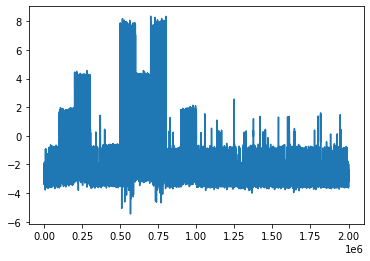

In [0]:
plt.plot(tdf['signal'])

In [0]:
tdf

,signal,grad_1,grad_2,grad_3,grad_4,lowpass_lf_0.0100,lowpass_ff_0.0100,lowpass_lf_0.0154,lowpass_ff_0.0154,lowpass_lf_0.0239,lowpass_ff_0.0239,lowpass_lf_0.0369,lowpass_ff_0.0369,lowpass_lf_0.0570,lowpass_ff_0.0570,lowpass_lf_0.0880,lowpass_ff_0.0880,lowpass_lf_0.1359,lowpass_ff_0.1359,lowpass_lf_0.2100,lowpass_ff_0.2100,lowpass_lf_0.3244,lowpass_ff_0.3244,lowpass_lf_0.5012,lowpass_ff_0.5012,highpass_lf_0.0100,highpass_ff_0.0100,highpass_lf_0.0163,highpass_ff_0.0163,highpass_lf_0.0264,highpass_ff_0.0264,highpass_lf_0.0430,highpass_ff_0.0430,highpass_lf_0.0699,highpass_ff_0.0699,highpass_lf_0.1136,highpass_ff_0.1136,highpass_lf_0.1848,highpass_ff_0.1848,highpass_lf_0.3005,...,roll_std_100,roll_min_100,roll_max_100,roll_range_100,roll_median_100,roll_mean_500,roll_std_500,roll_min_500,roll_max_500,roll_range_500,roll_median_500,roll_mean_1000,roll_std_1000,roll_min_1000,roll_max_1000,roll_range_1000,roll_median_1000,ewm_mean_5,ewm_std_5,ewm_mean_10,ewm_std_10,ewm_mean_50,ewm_std_50,ewm_mean_100,ewm_std_100,ewm_mean_500,ewm_std_500,ewm_mean_1000,ewm_std_1000,signal_shift_pos_1,signal_shift_neg_1,signal_shift_pos_2,signal_shift_neg_2,signal_shift_pos_3,signal_shift_neg_3,signal_mfcc_128,signal_mfcc_256,signal_mfcc_512,signal_mfcc_1024,raw_signal
0,-2.650391,-0.195312,0.094055,0.104309,-0.095886,-2.650391,-2.628906,-2.650391,-2.632812,-2.650391,-2.640625,-2.650391,-2.648438,-2.650391,-2.652344,-2.650391,-2.652344,-2.650391,-2.652344,-2.650391,-2.652344,-2.650391,-2.650391,-2.650391,-2.650391,0.000000,-0.023331,-0.000000,-0.018295,0.000000,-0.008987,0.000000,-0.001199,0.000000,0.001442,0.000000,0.000788,0.000000,0.000168,0.000000,...,0.226074,-3.121094,-2.251953,0.868652,-2.675781,-2.685547,0.257812,-3.378906,-1.992188,1.386719,-2.687500,-2.697266,0.248291,-3.378906,-1.992188,1.386719,-2.689453,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,-2.650391,0.000000,0.000000,-2.845703,0.000000,-2.853516,0.000000,-2.443359,-48.21875,-59.21875,-58.09375,-41.90625,-2.650391
1,-2.845703,-0.101257,0.198364,0.008453,-0.134766,-2.654297,-2.628906,-2.656250,-2.634766,-2.658203,-2.644531,-2.662109,-2.654297,-2.667969,-2.660156,-2.675781,-2.666016,-2.685547,-2.673828,-2.701172,-2.697266,-2.720703,-2.738281,-2.750000,-2.800781,-0.192383,-0.217163,-0.190430,-0.211182,-0.187500,-0.200195,-0.182983,-0.189819,-0.175903,-0.183472,-0.165527,-0.176758,-0.150391,-0.158447,-0.129272,...,0.223999,-3.121094,-2.251953,0.868652,-2.685547,-2.685547,0.257568,-3.378906,-1.992188,1.386719,-2.687500,-2.699219,0.248291,-3.378906,-1.992188,1.386719,-2.689453,-2.767578,0.138184,-2.757812,0.138184,-2.750000,0.138184,-2.750000,0.138184,-2.750000,0.138184,-2.750000,0.138184,-2.650391,-2.853516,0.000000,-2.443359,0.000000,-2.613281,-48.21875,-59.21875,-58.09375,-41.90625,-2.849609
2,-2.853516,0.201416,0.110962,-0.165283,-0.054779,-2.660156,-2.630859,-2.666016,-2.636719,-2.671875,-2.646484,-2.683594,-2.658203,-2.697266,-2.664062,-2.718750,-2.667969,-2.744141,-2.671875,-2.777344,-2.685547,-2.814453,-2.712891,-2.849609,-2.750000,-0.193481,-0.223022,-0.187988,-0.216431,-0.179443,-0.204346,-0.166504,-0.192993,-0.147461,-0.187012,-0.120972,-0.183594,-0.086792,-0.172729,-0.046692,...,0.221924,-3.121094,-2.251953,0.868652,-2.675781,-2.687500,0.257812,-3.378906,-1.992188,1.386719,-2.687500,-2.697266,0.248291,-3.378906,-1.992188,1.386719,-2.689453,-2.808594,0.102478,-2.796875,0.109070,-2.787109,0.113770,-2.785156,0.114380,-2.785156,0.114807,-2.783203,0.114868,-2.845703,-2.443359,-2.650391,-2.613281,0.000000,-2.568359,-48.21875,-59.21875,-58.09375,-41.90625,-2.859375
3,-2.443359,0.120667,-0.132080,-0.101135,0.110352,-2.660156,-2.632812,-2.664062,-2.638672,-2.669922,-2.648438,-2.679688,-2.660156,-2.689453,-2.666016,-2.701172,-2.664062,-2.710938,-2.656250,-2.710938,-2.642578,-2.695312,-2.623047,-2.648438,-2.587891,0.216187,0.188354,0.221191,0.195312,0.228516,0.208008,0.238647,0.219482,0.251221,0.222656,0.263428,0.216064,0.268799,0.203491,0

In [0]:
def create_mpl(shape):
    '''
    Returns a keras model
    '''
    
    X_input = L.Input(shape)
    
    X = L.Dense(150, activation='relu')(X_input)
    X = L.Dense(150, activation='relu')(X)
    X = L.Dense(125, activation='relu')(X)
    X = L.Dense(100, activation='relu')(X)
    X = L.Dense(75, activation='relu')(X)
    X = L.Dense(50, activation='relu')(X)
    X = L.Dense(25, activation='relu')(X)
    X = L.Dense(11, activation='softmax')(X)

    # X = L.Dense(150, activation='LeakyReLU')(X_input)
    # X = L.Dense(150, activation='LeakyReLU')(X)
    # X = L.Dense(125, activation='LeakyReLU')(X)
    # X = L.Dense(75, activation='LeakyReLU')(X)
    # X = L.Dense(50, activation='LeakyReLU')(X)
    # X = L.Dense(25, activation='LeakyReLU')(X)
    # X = L.Dense(11, activation='softmax')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model


In [0]:
def f1_score_calc(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

# K-Fold with MLP.

In [0]:
from sklearn.model_selection import StratifiedKFold
i=1;
n_fold = 4 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=17)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],11))
for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    print(i,"*******th fold**************")
    
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    mlp = create_mpl(X_train[0].shape)
    mlp.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
    mlp.fit(x=X_train, y=y_train, epochs=50, batch_size=1024, class_weight=class_weight)
    pred = mlp.predict(X_valid)
    pred = np.argmax(pred,axis=-1)
    score = f1_score_calc(y_valid, pred)
    print(score)
    #scores.append(score)
    y_pred = mlp.predict(tdf) 
    prediction += y_pred
    i = i+1

prediction /= n_fold
#print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))



In [0]:
sub = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')
sub['open_channels'] =  np.argmax(prediction, axis=-1)

sub.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/4_fold_mlp.csv', index=False, float_format='%.4f')
sub.head(10)



0          0
1          0
2          0
3          0
4          0
          ..
4999995    7
4999996    7
4999997    8
4999998    9
4999999    9
Name: open_channels, Length: 5000000, dtype: int64

In [0]:

from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn import metrics
i=1;
n_fold = 5 # amount of data folds
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)
scores = []
prediction = np.zeros(shape=(tdf.shape[0],1))

params = {'boosting_type': 'gbdt',
          'metric': 'rmse',
          'objective': 'regression',
          'n_jobs': -1,
          'seed': 236}
          # 'num_leaves': 280,
          # 'learning_rate': 0.026623466966581126,
          # 'max_depth': 73,
          # 'lambda_l1': 2.959759088169741,
          # 'lambda_l2': 1.331172832164913,
          # 'bagging_fraction': 0.9655406551472153,
          # 'bagging_freq': 9,
          # 'colsample_bytree': 0.6867118652742716}

oof_pred = np.zeros(len(X))
# y_pred = np.zeros(shape=(tdf.shape[0], 1))
y_pred = []
train_pred = []

for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index] # train and validation data splits
    y_train, y_valid = y[train_index], y[valid_index]
    X_train = X_train.values
    X_valid = X_valid.values
    train_set = lgb.Dataset(X_train, y_train)
    val_set = lgb.Dataset(X_valid, y_valid)
    
    model = lgb.train(params, train_set, num_boost_round = 5000, early_stopping_rounds = 100, 
                      valid_sets = [train_set, val_set], verbose_eval = 100)
    
    oof_pred[valid_index] = model.predict(X_valid)
    # y_pred += model.predict(tdf) / folds.n_splits
    y_pred.append(model.predict(tdf))
    train_pred.append(model.predict(X))
    # break
    
rmse_score = np.sqrt(metrics.mean_squared_error(y, oof_pred))
# want to clip and then round predictions (you can get a better performance using optimization to found the best cuts)
oof_pred = np.round(np.clip(oof_pred, 0, 10)).astype(int)
round_y_pred = np.round(np.clip(y_pred, 0, 10)).astype(int)
f1 = metrics.f1_score(y, oof_pred, average = 'macro')
print(f'Our oof rmse score is {rmse_score}')
print(f'Our oof macro f1 score is {f1}')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.156754	valid_1's rmse: 0.1575
[200]	training's rmse: 0.155108	valid_1's rmse: 0.156596
[300]	training's rmse: 0.153959	valid_1's rmse: 0.156085
[400]	training's rmse: 0.153077	valid_1's rmse: 0.15585
[500]	training's rmse: 0.152276	valid_1's rmse: 0.15565
[600]	training's rmse: 0.151565	valid_1's rmse: 0.155484
[700]	training's rmse: 0.150879	valid_1's rmse: 0.155354
[800]	training's rmse: 0.150234	valid_1's rmse: 0.15524
[900]	training's rmse: 0.149642	valid_1's rmse: 0.155176
[1000]	training's rmse: 0.149072	valid_1's rmse: 0.155112
[1100]	training's rmse: 0.148528	valid_1's rmse: 0.155041
[1200]	training's rmse: 0.147961	valid_1's rmse: 0.154966
[1300]	training's rmse: 0.147444	valid_1's rmse: 0.154921
[1400]	training's rmse: 0.146942	valid_1's rmse: 0.154876
[1500]	training's rmse: 0.146426	valid_1's rmse: 0.154825
[1600]	training's rmse: 0.145971	valid_1's rmse: 0.15482
[1700]	training's rmse: 

In [0]:
def make_group(list_df):
  list_df_ = []
  for i in range(5):
    list_tmp = []
    if(i == 0):
      list_tmp.extend(list_df[0:B_SIZE])
      list_tmp.extend(list_df[B_SIZE:2*B_SIZE])
    if(i == 1):
      list_tmp.extend(list_df[2*B_SIZE:3*B_SIZE])
      list_tmp.extend(list_df[6*B_SIZE:7*B_SIZE])
    if(i == 2):
      list_tmp.extend(list_df[3*B_SIZE:4*B_SIZE])
      list_tmp.extend(list_df[7*B_SIZE:8*B_SIZE])
    if(i == 3):
      list_tmp.extend(list_df[4*B_SIZE:5*B_SIZE])
      list_tmp.extend(list_df[9*B_SIZE:10*B_SIZE])
    if(i == 4):
      list_tmp.extend(list_df[5*B_SIZE:6*B_SIZE])
      list_tmp.extend(list_df[8*B_SIZE:9*B_SIZE])
    # print(len(list_tmp))

    list_df_.append(list_tmp)

  return list_df_

In [0]:
df_score = pd.DataFrame()
list_score = []
for i in range(10):
  f1 = metrics.f1_score(y[i*B_SIZE:(i+1)*B_SIZE], oof_pred[i*B_SIZE:(i+1)*B_SIZE], average = 'macro')
  list_score.append(f1)
  print(f'Our oof macro f1 score is {f1}')


# df_score['score'] = list_score
# df_score.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/batchscore.csv')

Our oof macro f1 score is 0.9973826232328794
Our oof macro f1 score is 0.6646060268342565
Our oof macro f1 score is 0.9969363309402262
Our oof macro f1 score is 0.7890757325322708
Our oof macro f1 score is 0.7808766994652747
Our oof macro f1 score is 0.9725743980480167
Our oof macro f1 score is 0.9968189881684585
Our oof macro f1 score is 0.7692688667892305
Our oof macro f1 score is 0.9717279846924239
Our oof macro f1 score is 0.8544075621755223


In [0]:
y_group = make_group(y)
# y_group[0]
oof_pred_group = make_group(oof_pred)
for i in range(5):
  f1 = metrics.f1_score(y_group[i], oof_pred_group[i], average = 'macro')
  # list_score.append(f1)
  print(f'group {i} oof macro f1 score is {f1}')

group 0 oof macro f1 score is 0.6647495914652932
group 1 oof macro f1 score is 0.9968782453269129
group 2 oof macro f1 score is 0.7790790591639134
group 3 oof macro f1 score is 0.7787184310605059
group 4 oof macro f1 score is 0.9721449760505165


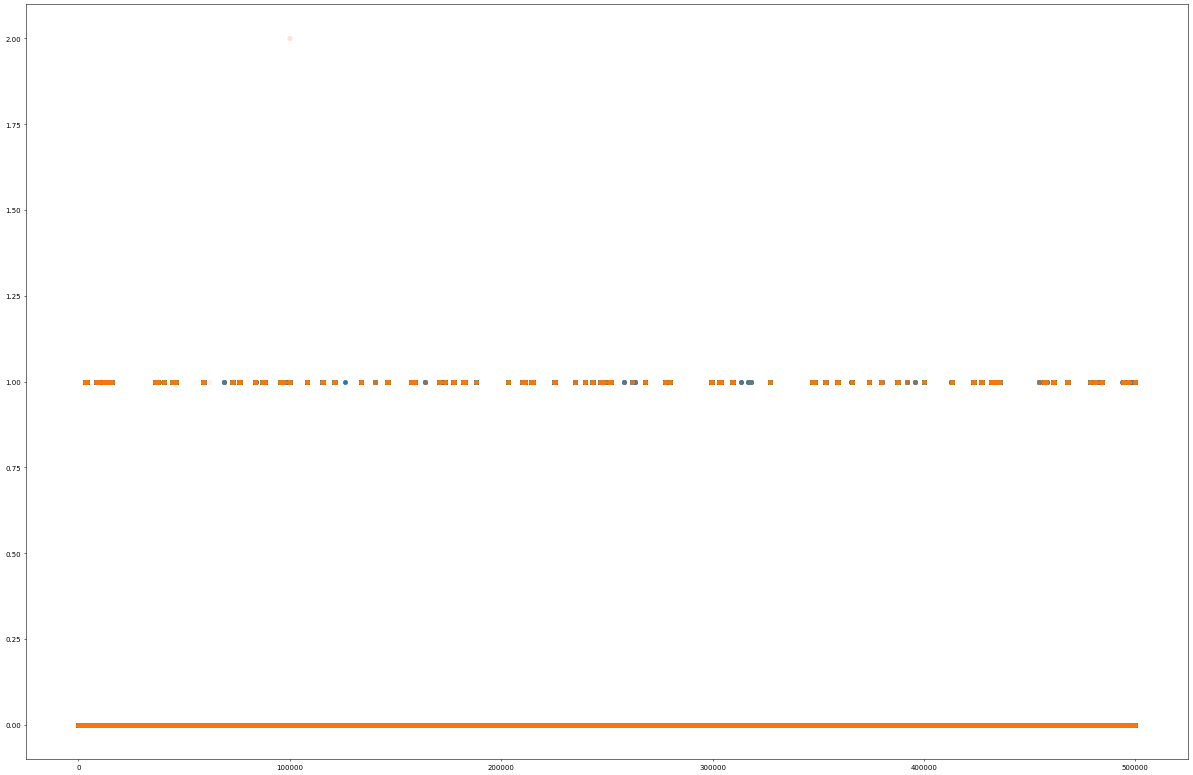

In [0]:
plt.figure(figsize=(30, 20), dpi=50)
x = np.arange(B_SIZE)
plt.scatter(x, y[1*B_SIZE:(1+1)*B_SIZE])
plt.scatter(x, oof_pred[1*B_SIZE:(1+1)*B_SIZE], alpha=0.1)

In [0]:
for i in range(len(y_pred)):
  if i == 0:
    predpred = y_pred[i] / folds.n_splits
  else:
    predpred += y_pred[i] / folds.n_splits

round_y_pred = np.round(np.clip(predpred, 0, 10)).astype(int)

submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')

submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sub.csv', index = False, float_format='%.4f')
submission.head(20)

,time,open_channels
0,500.0001,0
1,500.0002,0
2,500.0003,0
3,500.0004,0
4,500.0005,0
5,500.0006,0
6,500.0007,0
7,500.0008,0
8,500.0009,0
9,500.0010,0


In [0]:
for i in range(len(train_pred)):
  if i == 0:
    predpred = train_pred[i] / folds.n_splits
  else:
    predpred += train_pred[i] / folds.n_splits

round_y_pred = predpred

# submission = pd.read_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/sample_submission.csv')
submission = pd.DataFrame()
submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/train_sub.csv', index = False, float_format='%.4f')
submission.head(20)

,open_channels
0,0.020903
1,-0.000700
2,-0.002615
3,-0.001245
4,0.000039
5,-0.000131
6,0.000122
7,0.000153
8,0.000150
9,-0.000096


In [0]:
for i in range(len(y_pred)):
  if i == 0:
    predpred = y_pred[i] / folds.n_splits
  else:
    predpred += y_pred[i] / folds.n_splits

round_y_pred = predpred

submission = pd.DataFrame()
submission['open_channels'] = round_y_pred
submission.to_csv('./drive/My Drive/Colab Notebooks/liverpool-ion-switching/test_sub.csv', index = False, float_format='%.4f')
submission.head(20)

NameError: ignored

In [0]:
submission

,open_channels
0,0.017857
1,-0.000721
2,-0.000624
3,-0.000303
4,0.000030
...,...
1999995,-0.000222
1999996,-0.000098
1999997,-0.000173
1999998,-0.000038
